<a href="https://colab.research.google.com/github/sahilfaizal01/NLP-Resources/blob/main/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install sentence-transformers

In [5]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer

In [6]:
#%% import data
twitter_file = '/content/Tweets.csv'
df = pd.read_csv(twitter_file).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
8185,a5ab0d4fc5,HAHAHAHA...yeah you mess up that crossing and...,mess,negative
8186,6e1e864851,Cleaned out me Followers List and blocked the ...,spammer,negative
8187,09b19e96f2,I had one of those in south Florida. Mowing a...,I had one of those in south Florida. Mowing ar...,neutral
8188,44a1d81a8f,I would advise watching it in the cinema. I a...,I am sure the effects are worth it.,positive


In [7]:
#%% Create Target Variable
cat_id = {'neutral': 1,
          'negative': 0,
          'positive': 2}

df['class'] = df['sentiment'].map(cat_id)

In [8]:
#%% Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 80
MAX_FEATURES = 10

In [9]:
#%% Embedding Model
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

sentences = [ "Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(768,)


In [10]:
#%% prepare X and y
X = emb_model.encode(df['text'].values)

with open("/content/tweets_X.pkl", "wb") as output_file:
  pickle.dump(X, output_file)

In [11]:
with open("/content/tweets_X.pkl", "rb") as input_file:
  X = pickle.load(input_file)

y = df['class'].values

In [12]:
#%% Train Val Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [13]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]


train_ds = SentimentData(X= X_train, y = y_train)
test_ds = SentimentData(X_test, y_test)

In [14]:
# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [15]:
# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [16]:
#%% Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train.shape[1], NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [17]:
# %% Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 35.82095170021057
Epoch 1, Loss: 34.38196527957916
Epoch 2, Loss: 32.55144387483597
Epoch 3, Loss: 30.453171849250793
Epoch 4, Loss: 28.4677734375
Epoch 5, Loss: 26.889672696590424
Epoch 6, Loss: 25.707047045230865
Epoch 7, Loss: 24.863077580928802
Epoch 8, Loss: 24.258820593357086
Epoch 9, Loss: 23.74837076663971
Epoch 10, Loss: 23.3708553314209
Epoch 11, Loss: 23.05813878774643
Epoch 12, Loss: 22.8024600148201
Epoch 13, Loss: 22.582704782485962
Epoch 14, Loss: 22.367115378379822
Epoch 15, Loss: 22.183820068836212
Epoch 16, Loss: 22.026663661003113
Epoch 17, Loss: 21.868620097637177
Epoch 18, Loss: 21.72065979242325
Epoch 19, Loss: 21.597529649734497
Epoch 20, Loss: 21.456400454044342
Epoch 21, Loss: 21.352005660533905
Epoch 22, Loss: 21.243033528327942
Epoch 23, Loss: 21.137960851192474
Epoch 24, Loss: 21.02966994047165
Epoch 25, Loss: 20.93303555250168
Epoch 26, Loss: 20.857729196548462
Epoch 27, Loss: 20.756012201309204
Epoch 28, Loss: 20.679256916046143
Epoch 29, Lo

<Axes: >

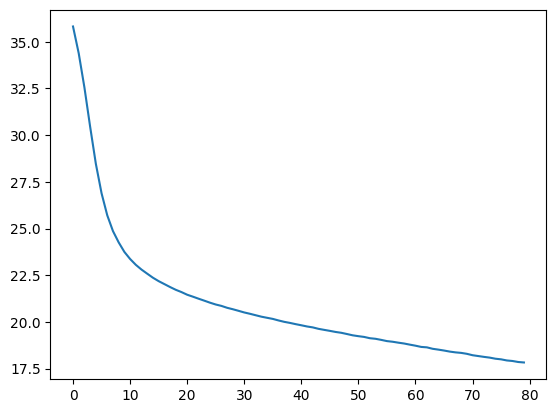

In [18]:
# %%
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)

In [19]:
# %% Model Evaluation
with torch.no_grad():
  for X_batch, y_batch in test_loader:
    y_test_pred_log = model(X_batch)
    y_test_pred = torch.argmax(y_test_pred_log, dim = 1)

In [20]:
# %%
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [21]:
# %%
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."
# %%
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 40.7 %
